# Atom Readout fidelity analysis
First done on 2025-11-08 to measure the fidelity of readout. First, I did a background measurement using atom_loading_experiment such that no atom is loaded. Then, I used atom_loading_2_experiment to load atom and do two ROs. The overlap between no-atom and atom signal histogram from RO2 indicates the fidelity of readout. 


In [18]:
date_filters = ["2025-11-08"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints
import math
import itertools

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan","Microwaves_scans"], # find files containing any of these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-08\12\000031525-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-08\12\000031526-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-08\12\000031526-GeneralVariableScan_atom_loading_scan_over_dummy_variable.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-08\13\000031527-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-08\13\000031527-GeneralVariableScan_atom_loading_scan_over_dummy_variable.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-08\13\000031529-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-08\13\000031529-GeneralVariableScan_atom_loading_2_scan_over_dummy_variable.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-08\15\000031530-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-m

experiment: atom_loading_experiment
override: {'t_FORT_drop':1000*us,'t_MOT_loading':10*ms}
# of iterations: 1
experiment: atom_loading_2_experiment
override: {'t_FORT_drop':0*us,'t_MOT_loading':10*ms,'t_delay_between_shots':1*ms}
# of iterations: 1
Background (no atom) data:
  N_dark                 = 1000
  N_dark→bright (>=thr)  = 0
  P(false positive|dark) = 0.000e+00 ± 0.000e+00
  F_dark                 = 1.000000 ± 0.000000

Atom-present (RO1-selected) data:
  Total pairs (RO1,RO2)          = 10000
  Selected as atom by RO1        = 9878  (0.988 of all)
  N_bright→dark (RO2 < thr)      = 43
  P(false negative|atom)         = 4.353e-03 ± 6.624e-04
  F_bright                       = 0.995647 ± 0.000662

Combined (average) detection fidelity:
  F_det = 0.995647 ± 0.000662


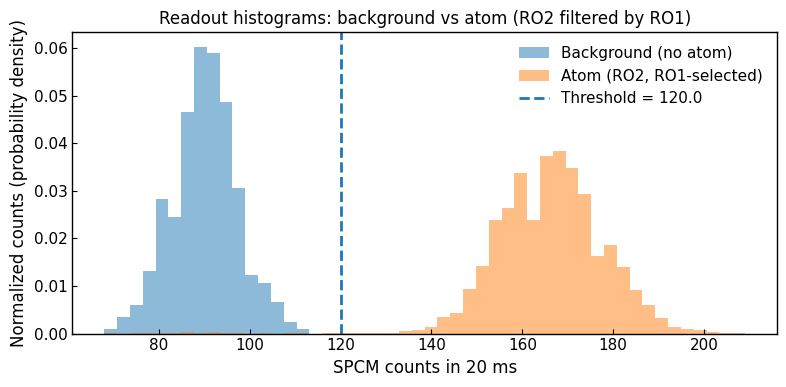

In [19]:
"""
Choose two experiment files for analysis; one is the background measurement experiment, the other is atom signal experiment. Often the background does not leak beyond threshold. 
Therefore, you can simply assume F_dark = 1.0, sigma_F_dark = 0.0 and set these manually below.

"""

f_idx_bkg = 3       ### file index for the background measurement experiment
f_idx_atom = 10      ### file index for the atom measurement experiment

############ background measurement experiment
fname_bkg = os.path.join(results, fnames[f_idx_bkg])
f_bkg = h5py.File(fname_bkg, "r")

### Load datasets/variables from the HDF5 into namespace
h5_archive_and_datasets_to_locals(f_bkg, parent_locals=locals(), quiet=True)

print("experiment:", experiment_function)
print("override:", override_ExperimentVariables)

iterations = len(scan_sequence1)
print("# of iterations:", iterations)

threshold = single_atom_threshold * t_SPCM_first_shot

xsteps_xform = lambda x: x
xlabel = scan_variable1_name

retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
    BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, threshold, otsu=False
)

bkg_counts = BothSPCMs_RO2 
############################################

############ atom measurement experiment
fname_atom = os.path.join(results, fnames[f_idx_atom])
f_atom = h5py.File(fname_atom, "r")

### Load datasets/variables from the HDF5 into namespace
h5_archive_and_datasets_to_locals(f_atom, parent_locals=locals(), quiet=True)

print("experiment:", experiment_function)
print("override:", override_ExperimentVariables)

iterations = len(scan_sequence1)
print("# of iterations:", iterations)

threshold = single_atom_threshold * t_SPCM_first_shot

xsteps_xform = lambda x: x
xlabel = scan_variable1_name

retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
    BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, threshold, otsu=False
)
###########################################

# ------------------------------------------------------------
# Step A: background-only statistics → F_dark
# ------------------------------------------------------------

N_dark = len(bkg_counts)
N_dark_to_bright = np.sum(bkg_counts >= threshold)

p_false_positive = N_dark_to_bright / N_dark if N_dark > 0 else np.nan
F_dark = 1.0 - p_false_positive

### Binomial error on p_false_positive (and thus on F_dark)
if N_dark > 0:
    sigma_p_fp = np.sqrt(p_false_positive * (1.0 - p_false_positive) / N_dark)
else:
    sigma_p_fp = np.nan
sigma_F_dark = sigma_p_fp  # same number

# F_dark = 1.0
# sigma_F_dark = 0.0

# ------------------------------------------------------------
# Step B: atom-present statistics using RO1 pre-selection → F_bright
# ------------------------------------------------------------

### Pre-select shots where RO1 indicates an atom was present
mask_atom = BothSPCMs_RO1 >= threshold
RO2_atom = BothSPCMs_RO2[mask_atom]

N_total_pairs = len(BothSPCMs_RO1)
N_bright = len(RO2_atom)

### false negatives: atom shots where RO2 < threshold
N_bright_to_dark = np.sum(RO2_atom < threshold)
p_false_negative = N_bright_to_dark / N_bright if N_bright > 0 else np.nan
F_bright = 1.0 - p_false_negative

### Binomial error on p_false_negative (and thus on F_bright)
if N_bright > 0:
    sigma_p_fn = np.sqrt(p_false_negative * (1.0 - p_false_negative) / N_bright)
else:
    sigma_p_fn = np.nan
sigma_F_bright = sigma_p_fn

# ------------------------------------------------------------
# Combined detection fidelity 
# ------------------------------------------------------------
### Choose the prior probability that a random shot has an atom.
### For an unconditioned experiment, you might use your measured loading rate.
### For "I know there's an atom" (conditioned on RO1), set p_atom = 1.0.
p_atom = 1.0 

F_det = p_atom * F_bright + (1.0 - p_atom) * F_dark

# Error propagation (assuming F_dark and F_bright are independent)
sigma_F_det = np.sqrt(
    (p_atom * sigma_F_bright)**2
    + ((1.0 - p_atom) * sigma_F_dark)**2
)

# ------------------------------------------------------------
# Print results
# ------------------------------------------------------------

print("===================================================")
print("Background (no atom) data:")
print(f"  N_dark                 = {N_dark}")
print(f"  N_dark→bright (>=thr)  = {N_dark_to_bright}")
print(f"  P(false positive|dark) = {p_false_positive:.3e} ± {sigma_p_fp:.3e}")
print(f"  F_dark                 = {F_dark:.6f} ± {sigma_F_dark:.6f}")
print()

print("Atom-present (RO1-selected) data:")
print(f"  Total pairs (RO1,RO2)          = {N_total_pairs}")
print(f"  Selected as atom by RO1        = {N_bright}  "
      f"({N_bright / N_total_pairs:.3f} of all)")
print(f"  N_bright→dark (RO2 < thr)      = {N_bright_to_dark}")
print(f"  P(false negative|atom)         = {p_false_negative:.3e} ± {sigma_p_fn:.3e}")
print(f"  F_bright                       = {F_bright:.6f} ± {sigma_F_bright:.6f}")
print()

print("Combined (average) detection fidelity:")
print(f"  F_det = {F_det:.6f} ± {sigma_F_det:.6f}")


# ------------------------------------------------------------
# Visualization: histograms of background vs atom RO2 with threshold
# ------------------------------------------------------------
### Decide on common binning
all_counts_for_range = np.concatenate([bkg_counts, RO2_atom]) if N_bright > 0 else bkg_counts
cmin = np.min(all_counts_for_range)
cmax = np.max(all_counts_for_range)

#### Choose a reasonable bin width 
nbins = 50
bins = np.linspace(cmin, cmax, nbins + 1)

plt.figure(figsize=(8, 4))

plt.hist(bkg_counts,
         bins=bins,
         alpha=0.5,
         label="Background (no atom)",
         density=True)

if N_bright > 0:
    plt.hist(RO2_atom,
             bins=bins,
             alpha=0.5,
             label="Atom (RO2, RO1-selected)",
             density=True)

plt.axvline(threshold, linestyle="--", linewidth=2,
            label=f"Threshold = {threshold}")

plt.xlabel(f"SPCM counts in {t_SPCM_first_shot*1000:.0f} ms")
plt.ylabel("Normalized counts (probability density)")
plt.title("Readout histograms: background vs atom (RO2 filtered by RO1)")
plt.legend()
plt.tight_layout()
plt.show()


Saved histogram figure to: single_atom_readout_hist.pdf


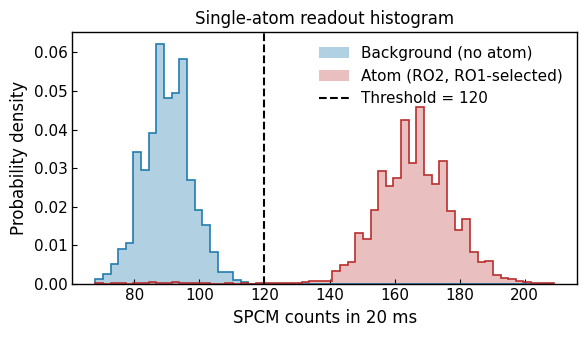

In [20]:
"""
Fancier histogram for publication.

"""

def plot_readout_histograms(
    bkg_counts,
    ro1,
    ro2,
    threshold,
    bins=60,
    savepath=None,
):
    """
    Make a publication-style histogram of SPCM counts:
    - Background-only shots
    - Atom shots (RO2, pre-selected by RO1 >= threshold)
    """
    bkg_counts = np.asarray(bkg_counts)
    ro1 = np.asarray(ro1)
    ro2 = np.asarray(ro2)

    # Pre-select “atom present” shots based on RO1
    mask_atom = ro1 >= threshold
    ro2_atom = ro2[mask_atom]

    # Common binning
    all_counts = np.concatenate([bkg_counts, ro2_atom])
    cmin, cmax = np.min(all_counts), np.max(all_counts)
    bins = np.linspace(cmin, cmax, bins + 1)

    # Colors (similar to what you often use)
    color_bkg = (34/255, 124/255, 174/255)   # blue-ish
    color_atom = (185/255, 46/255, 46/255)   # red-ish

    # Global style tweaks
    plt.rcParams.update({
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "axes.linewidth": 1.0,
        "legend.frameon": False,
    })

    fig, ax = plt.subplots(figsize=(6.0, 3.5))  # compact, good for a single-column figure

    # Background histogram
    ax.hist(
        bkg_counts,
        bins=bins,
        histtype="stepfilled",
        alpha=0.35,
        density=True,
        color=color_bkg,
        label="Background (no atom)",
    )
    ax.hist(
        bkg_counts,
        bins=bins,
        histtype="step",
        density=True,
        color=color_bkg,
        linewidth=1.2,
    )

    # Atom histogram (RO2, pre-selected by RO1)
    ax.hist(
        ro2_atom,
        bins=bins,
        histtype="stepfilled",
        alpha=0.30,
        density=True,
        color=color_atom,
        label="Atom (RO2, RO1-selected)",
    )
    ax.hist(
        ro2_atom,
        bins=bins,
        histtype="step",
        density=True,
        color=color_atom,
        linewidth=1.2,
    )

    # Threshold line
    ax.axvline(
        threshold,
        linestyle="--",
        linewidth=1.5,
        color="k",
        label=f"Threshold = {threshold:.0f}",
    )

    ax.set_xlabel("SPCM counts in 20 ms")
    ax.set_ylabel("Probability density")
    ax.set_title("Single-atom readout histogram")

    # Put the legend outside to avoid hiding data
    ax.legend(loc="upper right")

    plt.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        print(f"Saved histogram figure to: {savepath}")

    return fig, ax

# -------------------------------------------------------------------
# Example call, assuming you already have:
#   bkg_counts, BothSPCMs_RO1, BothSPCMs_RO2, threshold
# -------------------------------------------------------------------

fig, ax = plot_readout_histograms(
    bkg_counts=bkg_counts,
    ro1=BothSPCMs_RO1,
    ro2=BothSPCMs_RO2,
    threshold=threshold,
    bins=60,
    savepath="single_atom_readout_hist.pdf",  # or None
)
plt.show()


# Blowaway fidelity analysis
First done on 2025-11-10 to measure the fidelity of blowaway. I need four experiments for this:
1- Retention after pumping atom into F=1, no blowaway
2- Retention after pumping atom into F=1, with blowaway
3- Retention after pumping atom into F=2, no blowaway
4- Retention after pumping atom into F=2, with blowaway


In [1]:
date_filters = ["2025-11-10"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints
import math
import itertools

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan","Microwaves_scans"], # find files containing any of these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-10\08\000031547-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-10\09\000031550-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-10\09\000031550-GeneralVariableScan_blowaway_fidelity_measurement_scan_over_t_depumping.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-10\09\000031551-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-10\09\000031551-GeneralVariableScan_blowaway_fidelity_measurement_scan_over_dummy_variable.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-10\09\000031552-GeneralVariableScan.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-10\09\000031552-GeneralVariableScan_blowaway_fidelity_measurement_scan_over_dummy_variable.h5
C:\Networking Experiment\artiq codes\artiq-master\results\2025-11-10\09\000031553-GeneralVariableScan.h

In [2]:
"""
Choose the four experiment files for analysis:
1- R1_nB = Retention after pumping atom into F=1, no blowaway 
2- R1_wB = Retention after pumping atom into F=1, with blowaway 
3- R2_nB = Retention after pumping atom into F=2, no blowaway 
4- R2_wB = Retention after pumping atom into F=2, with blowaway

For each file first combine different iterations (scan over dummy_variable). 
"""

f_idx_1= 18       ### file index
f_idx_2= 20       ### file index
f_idx_3= 21       ### file index
f_idx_4= 23       ### file index


############ experiment 1:  pumping atom into F=1, no blowaway 
fname_1 = os.path.join(results, fnames[f_idx_1])
f_1 = h5py.File(fname_1, "r")

### Load datasets/variables from the HDF5 into namespace
h5_archive_and_datasets_to_locals(f_1, parent_locals=locals(), quiet=True)

print("experiment:", experiment_function)
print("override:", override_ExperimentVariables)

iterations = len(scan_sequence1)
print("# of iterations:", iterations)

threshold = single_atom_threshold * t_SPCM_first_shot

xsteps_xform = lambda x: x
xlabel = scan_variable1_name

retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
    BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, threshold, otsu=False
)

R1_nB = np.average(retention_array)
dR1_nB = np.average(binomial_err(n_atoms_loaded_array,retention_array)) ### error
############################################

############ experiment 2:  pumping atom into F=1, with blowaway 
fname_2 = os.path.join(results, fnames[f_idx_2])
f_2 = h5py.File(fname_2, "r")

### Load datasets/variables from the HDF5 into namespace
h5_archive_and_datasets_to_locals(f_2, parent_locals=locals(), quiet=True)

print("experiment:", experiment_function)
print("override:", override_ExperimentVariables)

iterations = len(scan_sequence1)
print("# of iterations:", iterations)

threshold = single_atom_threshold * t_SPCM_first_shot

xsteps_xform = lambda x: x
xlabel = scan_variable1_name

retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
    BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, threshold, otsu=False
)

R1_wB = np.average(retention_array)
dR1_wB = np.average(binomial_err(n_atoms_loaded_array,retention_array)) ### error
############################################

############ experiment 3:  pumping atom into F=2, no blowaway 
fname_3 = os.path.join(results, fnames[f_idx_3])
f_3 = h5py.File(fname_3, "r")

### Load datasets/variables from the HDF5 into namespace
h5_archive_and_datasets_to_locals(f_3, parent_locals=locals(), quiet=True)

print("experiment:", experiment_function)
print("override:", override_ExperimentVariables)

iterations = len(scan_sequence1)
print("# of iterations:", iterations)

threshold = single_atom_threshold * t_SPCM_first_shot

xsteps_xform = lambda x: x
xlabel = scan_variable1_name

retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
    BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, threshold, otsu=False
)

R2_nB = np.average(retention_array) 
dR2_nB = np.average(binomial_err(n_atoms_loaded_array,retention_array)) ### error
############################################

############ experiment 4:  pumping atom into F=2, with blowaway 
fname_4 = os.path.join(results, fnames[f_idx_4])
f_4 = h5py.File(fname_4, "r")

### Load datasets/variables from the HDF5 into namespace
h5_archive_and_datasets_to_locals(f_4, parent_locals=locals(), quiet=True)

print("experiment:", experiment_function)
print("override:", override_ExperimentVariables)

iterations = len(scan_sequence1)
print("# of iterations:", iterations)

threshold = single_atom_threshold * t_SPCM_first_shot

xsteps_xform = lambda x: x
xlabel = scan_variable1_name

retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
    BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, threshold, otsu=False
)

R2_wB = np.average(retention_array[0:7]) ### I stopped the experiment because it was too long. So only the first [0:7] iterations.
dR2_wB = np.average(binomial_err(n_atoms_loaded_array[0:7],retention_array[0:7])) ### error
############################################



experiment: blowaway_fidelity_measurement_experiment
override: {'t_blowaway':150*us}
# of iterations: 10
experiment: blowaway_fidelity_measurement_experiment
override: {'t_blowaway':150*us}
# of iterations: 10
experiment: blowaway_fidelity_measurement_experiment
override: {'t_blowaway':150*us}
# of iterations: 10
experiment: blowaway_fidelity_measurement_experiment
override: {'t_blowaway':150*us}
# of iterations: 10
iteration 9, no measurements


In [3]:
"""
Calculating the blowaway fidelity from the above values.

"""

F_RO = 0.995647 ### readout fidelity measured separately.
dF_RO = 0.000662

def correct_for_readout(R, dR, F_RO, dF_RO):
    """
    Correct measured retention R for finite readout fidelity F_RO,
    including uncertainties in both R and F_RO.
    """
    denom = 2.0 * F_RO - 1.0   
    num   = R - (1.0 - F_RO)  

    S = num / denom

    # derivatives
    dS_dR = 1.0 / denom
    dS_dF = (1.0 - 2.0 * R) / (denom**2)

    dS = np.sqrt((dS_dR * dR)**2 + (dS_dF * dF_RO)**2)
    return S, dS


### retentions corrected for readout fidelity
S1_nB, dS1_nB = correct_for_readout(R1_nB, dR1_nB, F_RO, dF_RO)
S1_wB, dS1_wB = correct_for_readout(R1_wB, dR1_wB, F_RO, dF_RO)
S2_nB, dS2_nB = correct_for_readout(R2_nB, dR2_nB, F_RO, dF_RO)
S2_wB, dS2_wB = correct_for_readout(R2_wB, dR2_wB, F_RO, dF_RO)

### s1: conditional probability that atom is in F=1, and showed in RO: P(RO>threshold | F=1)
s1 = S1_wB / S1_nB
ds1 = np.sqrt(
    (dS1_wB / S1_nB)**2 +
    (S1_wB * dS1_nB / (S1_nB**2))**2
)

### e2: conditional probability that atom is in F=2, and ejected, i.e. does not show in RO: P(RO<threshold | F=2)
e2 = 1.0 - S2_wB / S2_nB
de2 = np.sqrt(
    (dS2_wB / S2_nB)**2 +
    (S2_wB * dS2_nB / (S2_nB**2))**2
)


### average and minimum (a more conservative) fidelity of blowaway
F_BA = (s1+e2)/2 
dF_BA = 0.5 * np.sqrt(ds1**2 + de2**2)

F_BA_min = min(s1, e2)
dF_BA_min = ds1 if s1 <= e2 else de2


P_F1_correct = F_RO * s1 + (1-F_RO)*(1-s1) ### conditional probability for atom in F=1 and measured correctly in the readout
P_F2_correct = F_RO * e2 + (1-F_RO)*(1-e2) ### conditional probability for atom in F=2 and measured correctly in the readout

dP_coeff = 2*F_RO - 1.0 
dP_F1 = abs(dP_coeff) * ds1
dP_F2 = abs(dP_coeff) * de2

F_hyperfine_selective_RO = 0.5 * (P_F1_correct + P_F2_correct)
dF_hyperfine_selective_RO = 0.5 * np.sqrt(dP_F1**2 + dP_F2**2)


print(f"s1 (F=1 survives blowaway)      = {s1:.4f} ± {ds1:.4f}")
print(f"e2 (F=2 ejected by blowaway)    = {e2:.4f} ± {de2:.4f}")
print(f"Blow-away fidelity (average)    = {F_BA:.4f} ± {dF_BA:.4f}")
print(f"Blow-away fidelity (minimum)    = {F_BA_min:.4f} ± {dF_BA_min:.4f}")
print(f"Overall hyperfine-selective RO      = {F_hyperfine_selective_RO:.4f} ± {dF_hyperfine_selective_RO:.4f}")

s1 (F=1 survives blowaway)      = 0.9970 ± 0.0038
e2 (F=2 ejected by blowaway)    = 0.9878 ± 0.0042
Blow-away fidelity (average)    = 0.9924 ± 0.0028
Blow-away fidelity (minimum)    = 0.9878 ± 0.0042
Overall state-selective RO      = 0.9881 ± 0.0028
